## Imports

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [3]:
combined = xr.open_dataset("combined.nc")
print(combined)

<xarray.Dataset> Size: 6MB
Dimensions:    (time: 13919, depth: 25, latitude: 1, longitude: 1)
Coordinates:
  * time       (time) datetime64[ns] 111kB 1987-01-01 1987-01-02 ... 2025-07-08
  * depth      (depth) float32 100B 1.018 3.166 5.465 7.92 ... 91.2 97.93 104.9
  * latitude   (latitude) float32 4B 42.98
  * longitude  (longitude) float32 4B 16.04
Data variables:
    uo         (time, depth, latitude, longitude) float32 1MB ...
    vo         (time, depth, latitude, longitude) float32 1MB ...
    mlotst     (time, latitude, longitude) float32 56kB ...
    so         (time, depth, latitude, longitude) float32 1MB ...
    thetao     (time, depth, latitude, longitude) float32 1MB ...
Attributes:
    Conventions:       CF-1.11
    title:             Horizontal Velocity (3D) - Daily Mean
    institution:       Centro Euro-Mediterraneo sui Cambiamenti Climatici - C...
    source:            MFS E3R1
    contact:           servicedesk.cmems@mercator-ocean.eu
    references:        Please 

C:\Users\bahne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xarray\conventions.py:204: SerializationWarning: variable 'uo' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
C:\Users\bahne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xarray\conventions.py:204: SerializationWarning: variable 'vo' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
C:\Users\bahne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xarray\conventions.py:204: SerializationWarning: variable 'mlotst' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder

In [4]:
bad_depths = [97.93, 104.9]

depths = combined['depth'].values
# Let's get the closest actual depths.
bad_indexes = []
for bd in bad_depths:
    idx = np.abs(depths - bd).argmin()
    bad_indexes.append(idx)

# Creating a mask to only keep the ones we want.
keep_mask = np.ones_like(depths, dtype=bool)
keep_mask[bad_indexes] = False
# Filtering
combined = combined.sel(depth=depths[keep_mask])

print(combined['depth'].values)


[ 1.0182366  3.1657474  5.4649634  7.9203773 10.536604  13.318384
 16.270586  19.39821   22.706392  26.2004    29.885643  33.767673
 37.852192  42.14504   46.65221   51.37986   56.334286  61.521957
 66.94949   72.62369   78.5515    84.74004   91.19663  ]


In [5]:
def plot_anomalies(feature: str, cmin, cmax, title):

    hov = combined[feature]  # Dimensions: time, depth, lat, lon

    dayofyear = hov['time'].dt.dayofyear
    climatology = hov.groupby(dayofyear).mean(dim='time')
    anomaly = hov.groupby(dayofyear) - climatology

    plt.figure(figsize=(8, 5))
    p = anomaly.plot(
        x='time',
        y='depth',
        cmap='coolwarm',
        yincrease=False,        # Depth decreasing.
        vmin=cmin,
        vmax=cmax
    )

    p.colorbar.set_label(title, fontsize=12)

    plt.title('')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Depth (m)', fontsize=12)
    plt.show()

# Anomalies over the years

### Temperature

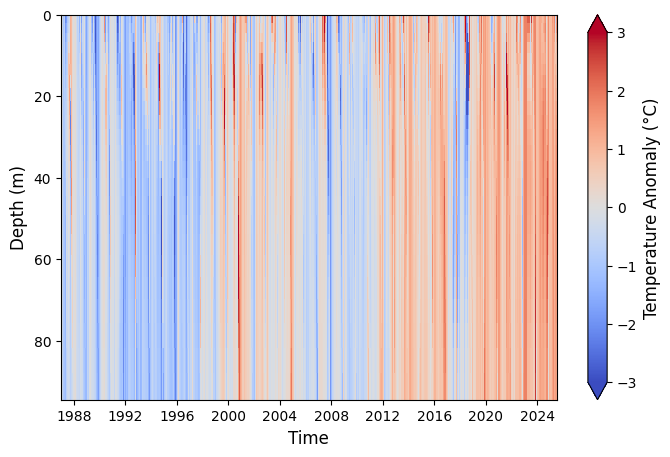

In [6]:
plot_anomalies("thetao", -3, 3, "Temperature Anomaly (°C)")

### Salinity

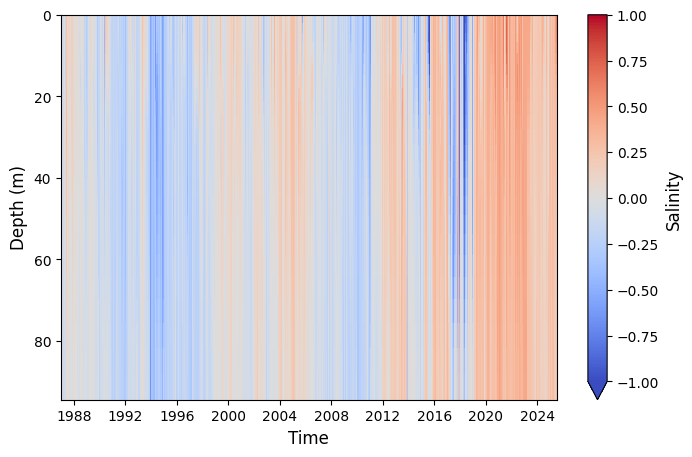

In [7]:
plot_anomalies("so", -1, 1, "Salinity")

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

def plot_hovmoeller(ds, var_name, title, year, contour_levels, mean_space=True, sigma=1.0, anomaly=False, cmin=-1, cmax=-1):
    ds = ds.sortby('depth')
    hov = ds[var_name]
    if mean_space:
        hov = hov.mean(dim=['latitude', 'longitude'])

    if anomaly:
        climatology = hov.groupby('time.dayofyear').mean('time')
        hov = hov.groupby('time.dayofyear') - climatology

    hov_year = hov.sel(time=slice(f'{year}-01-01', f'{year}-12-31'))

    cmin = hov_year.min().item() if cmin == -1 else cmin
    cmax = hov_year.max().item() if cmax == -1 else cmax

    arr = hov_year.values
    arr_smoothed = scipy.ndimage.gaussian_filter(arr, sigma=sigma)

    hov_year_smooth = xr.DataArray(
        arr_smoothed,
        dims=hov_year.dims,
        coords=hov_year.coords
    )

    fig, ax = plt.subplots(figsize=(8, 5))

    pcm = hov_year_smooth.plot(
        ax=ax,
        x='time',
        y='depth',
        cmap='viridis',
        vmin=cmin,
        vmax=cmax,
        yincrease=False,
        cbar_kwargs={'label': f'{var_name} (°C)', 'extend': 'neither'}
    )

    cs = hov_year_smooth.plot.contour(
        ax=ax,
        x='time',
        y='depth',
        levels=contour_levels,
        colors='black',
        linewidths=0.8,
        yincrease=False
    )

    ax.clabel(cs, fmt='%2.0f °C', fontsize=8)

    ax.set_title(f'{year}', fontsize=12)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Depth (m)', fontsize=12)
    pcm.colorbar.ax.tick_params(labelsize=10)
    pcm.colorbar.set_label(title, fontsize=12)

    plt.show()


# Hovmöller Plots

### Temperature

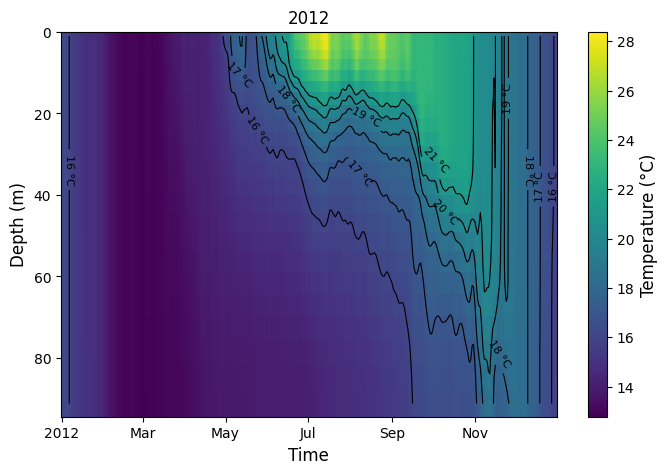

In [9]:
plot_hovmoeller(
    ds=combined,
    var_name='thetao',
    title="Temperature (°C)",
    year=2012,
    contour_levels=[16,17, 18, 19, 20, 21],
    mean_space=True,
    sigma=1,
    anomaly=False,
    cmin=-1,
    cmax=-1
)

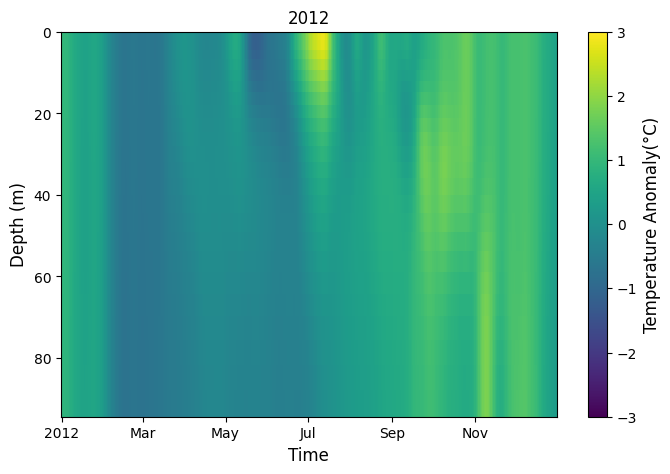

In [10]:
plot_hovmoeller(
    ds=combined,
    var_name='thetao',
    title="Temperature Anomaly(°C)",
    year=2012,
    contour_levels=[10],
    mean_space=True,
    sigma=3,
    anomaly=True,
    cmin=-3,
    cmax=3
)

### Salinity

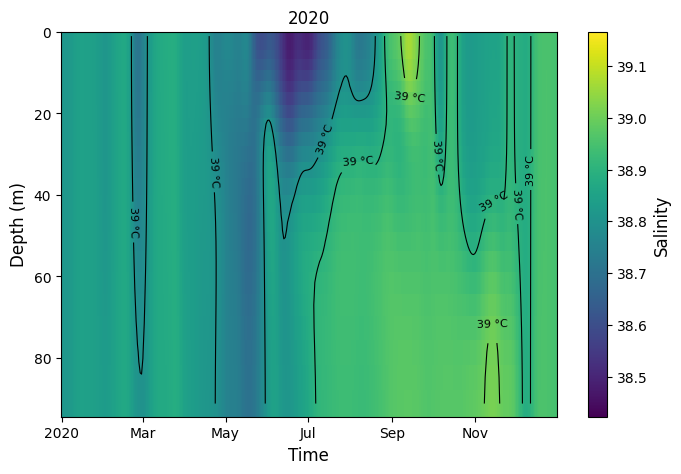

In [11]:
plot_hovmoeller(
    ds=combined,
    var_name='so',
    title="Salinity",
    year=2020,
    contour_levels=[38.8, 38.9, 39],
    mean_space=True,
    sigma=3,
    # cmin=38.4,
    # cmax=39
)

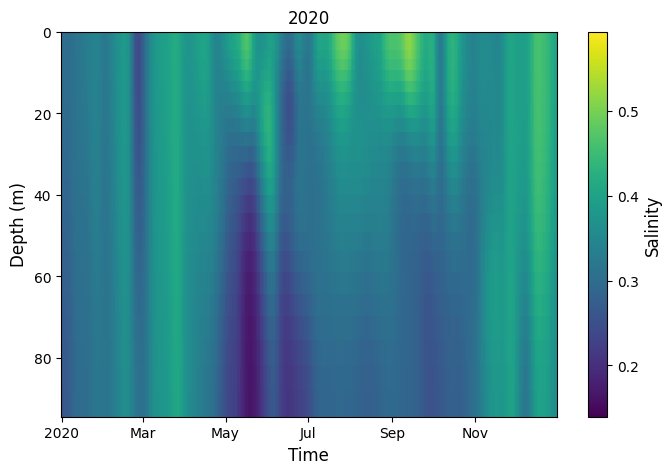

In [12]:
plot_hovmoeller(
    ds=combined,
    var_name='so',
    title="Salinity",
    year=2020,
    contour_levels=[10],
    mean_space=True,
    sigma=3,
    anomaly=True
)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import xarray as xr

def plot_hovmoeller_grid(
    ds, var_name, years, cmin, cmax, contour_levels, mean_space=True, sigma=1.0,
    nrows=2, ncols=4, anomaly=False, cbartitle=""
):
    ds = ds.sortby('depth')
    hov = ds[var_name]
    if mean_space:
        hov = hov.mean(dim=['latitude', 'longitude'])

    if anomaly:
        climatology = hov.groupby('time.dayofyear').mean('time')
        hov = hov.groupby('time.dayofyear') - climatology

    vmin = hov.min().item() if cmin == -1 else cmin
    vmax = hov.max().item() if cmax == -1 else cmax

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(2.5 * ncols, 2* nrows),
        sharex=False,
        sharey=True
    )

    axes = axes.flatten()
    pcolormesh = None

    for i, (ax, year) in enumerate(zip(axes, years)):
        hov_year = hov.sel(time=slice(f'{year}-01-01', f'{year}-12-31'))
        arr = hov_year.values
        arr_smoothed = scipy.ndimage.gaussian_filter(arr, sigma=sigma)
        hov_year_smooth = xr.DataArray(
            arr_smoothed,
            dims=hov_year.dims,
            coords=hov_year.coords
        )

        pcolormesh = hov_year_smooth.plot(
            ax=ax,
            x='time',
            y='depth',
            cmap='viridis',
            yincrease=False,
            add_colorbar=False,
            vmin=vmin,
            vmax=vmax
        )

        cs = hov_year_smooth.plot.contour(
            ax=ax,
            x='time',
            y='depth',
            levels=contour_levels,
            colors='black',
            linewidths=0.8,
            yincrease=False
        )

        ax.clabel(cs, fontsize=10)
        ax.text(
            0.03,   # X-Position in Achsenkoordinaten (0 = links)
            0.03,   # Y-Position in Achsenkoordinaten (0 = unten)
            f'{year}',
            ha='left',
            va='bottom',
            fontsize=10,
            color='black',   # Contrast
            transform=ax.transAxes,
            # bbox=dict(facecolor='black', alpha=0.3, pad=1, edgecolor='none')
        )

        row = i // ncols
        col = i % ncols

        if col == 0:
            ax.set_ylabel('')
        else:
            ax.set_ylabel('')

        if row != nrows - 1:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('')
            xticklabels = [item.get_text() for item in ax.get_xticklabels()]
            if xticklabels:
                xticklabels[0] = ''
            ax.set_xticklabels(xticklabels)
            

    for ax in axes[len(years):]:
        ax.set_visible(False)

    cbar_ax = fig.add_axes([0.2, 0, 0.6, 0.02])
    cbar = fig.colorbar(
        pcolormesh,
        cax=cbar_ax,
        orientation='horizontal'
    )
    cbar.set_label(cbartitle, fontsize=10)

    cbar.ax.tick_params(labelsize=10)

    fig.text(
        0.02, 0.5, 'Depth [m]', va='center', ha='center', rotation='vertical', fontsize=10
    )

    fig.text(
        0.5, 0.04, 'Time', va='center', ha='center', fontsize=10
    )
    plt.subplots_adjust(
        left=0.1,
        right=0.95,
        top=0.95,
        bottom=0.08,
        wspace=0.05,
        hspace=0.05
    )



    plt.show()


### Temperature

C:\Users\bahne\AppData\Local\Temp\ipykernel_6256\4095336108.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)
C:\Users\bahne\AppData\Local\Temp\ipykernel_6256\4095336108.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


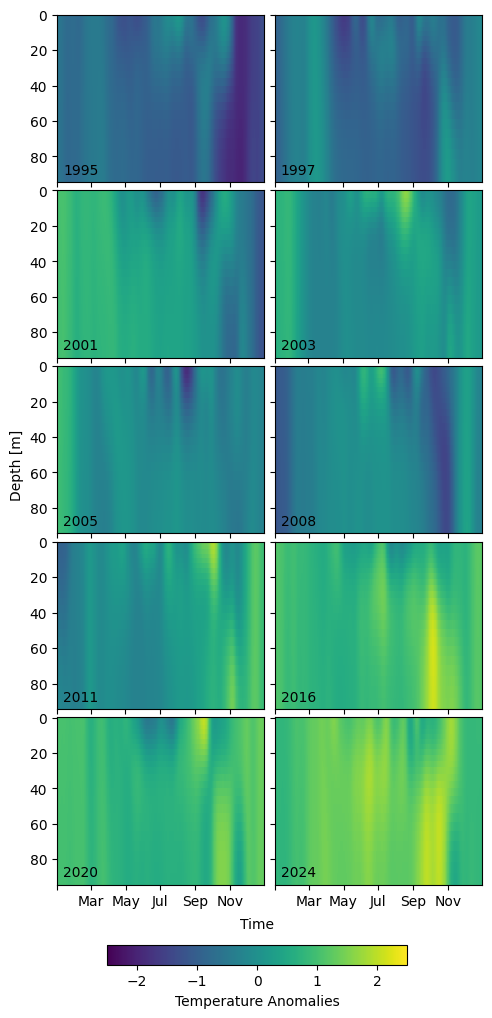

In [14]:
plot_hovmoeller_grid(
    ds=combined,
    var_name='thetao',
    years=[1995, 1997, 2001, 2003, 2005, 2008, 2011, 2016, 2020, 2024],
    cmin = -2.5,
    cmax = 2.5,
    contour_levels=[10],
    mean_space=True,
    sigma=5.0,
    nrows=5,
    ncols=2,
    anomaly=True,
    cbartitle="Temperature Anomalies"
)


### Salinity

C:\Users\bahne\AppData\Local\Temp\ipykernel_6256\4095336108.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)
C:\Users\bahne\AppData\Local\Temp\ipykernel_6256\4095336108.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


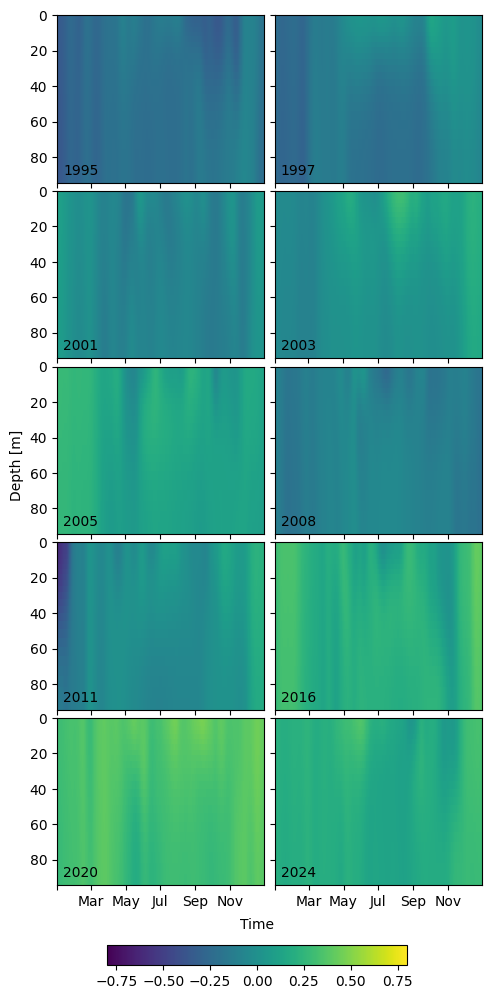

In [15]:
plot_hovmoeller_grid(
    ds=combined,
    var_name='so',
    years=[1995, 1997, 2001, 2003, 2005, 2008, 2011, 2016, 2020, 2024],
    cmin = -0.8,
    cmax = 0.8,
    contour_levels=[1995, 1997, 2001, 2003, 2005, 2008, 2011, 2016],
    mean_space=True,
    sigma=5.0,
    nrows=5,
    ncols=2,
    anomaly=True
)


# Mixed Layer Depth over year

### MLD

In [16]:
def plot_variables_overyear(data, title: str, ylabel: str):

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(mlotst['time'], data)

    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel(ylabel)
    ax.axhline(0, color='grey', linestyle='-', linewidth=0.8)
    ax.grid(True)
    ax.legend()
    plt.show()


C:\Users\bahne\AppData\Local\Temp\ipykernel_6256\3505155376.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


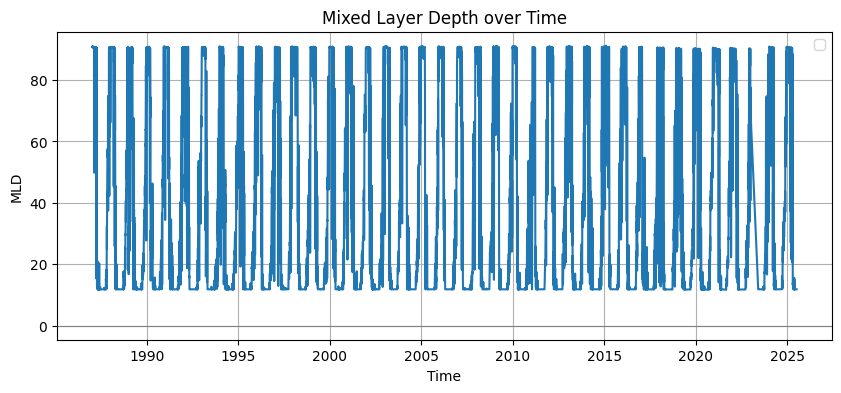

In [17]:
mlotst = combined['mlotst']
mlotst = mlotst.mean(dim=['latitude', 'longitude'])

plot_variables_overyear(mlotst, 'Mixed Layer Depth over Time', 'MLD')

### Anomalies

C:\Users\bahne\AppData\Local\Temp\ipykernel_6256\3505155376.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


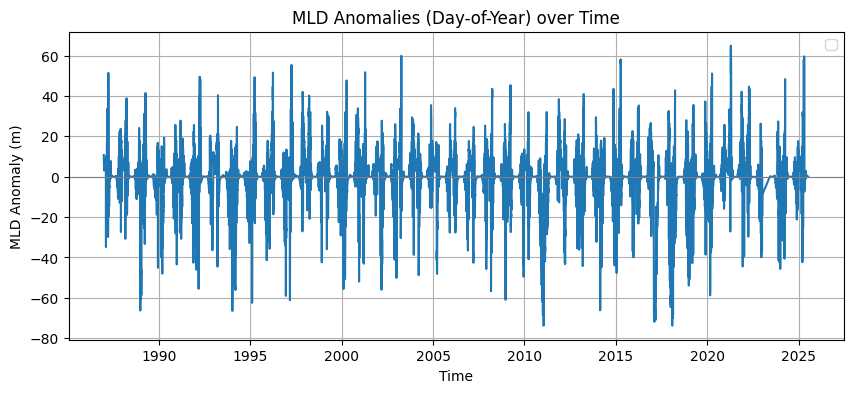

In [18]:
doy = mlotst['time'].dt.dayofyear
mean_doy = mlotst.groupby(doy).mean(dim='time')
anomalies = mlotst.groupby(doy) - mean_doy

plot_variables_overyear(anomalies.values, 'MLD Anomalies (Day-of-Year) over Time', 'MLD Anomaly (m)')

In [45]:
def plot_variables_overyear_selected_months_multiline(data, title: str, ylabel: str, months: list):

    fig, ax = plt.subplots(figsize=(10, 4))

    for month in months:
        data_month = data.sel(time=data['time.month'] == month)
        data_month_mean = data_month.groupby('time.year').mean('time')
        ax.plot(data_month_mean['year'], data_month_mean, label=f'Month {month:02d}')


    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel(ylabel)
    ax.axhline(0, color='grey', linestyle='-', linewidth=0.8)
    ax.grid(True)
    ax.legend(title='Months')
    ax.set_ylim(11, 17)
    plt.show()


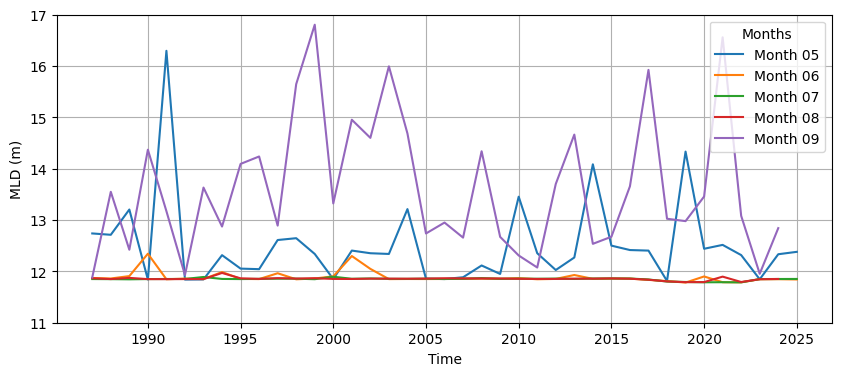

In [46]:
plot_variables_overyear_selected_months_multiline(
    mlotst,
    title="",
    ylabel="MLD (m)",
    months=[5,6,7, 8, 9]
)
